# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import copy
import numpy as np

import random

import torchvision
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import json
import cv2

import glob
import os

## Mount drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Set GPU

In [2]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

## Create a function for applying thresholding

In [4]:
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

## Transforms functions to preprocess images

In [5]:
data_transforms = {
 'train':transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize((256,256)),
        transforms.RandomRotation(degrees=(90), fill=255),
        transforms.ToTensor(),
        ThresholdTransform(thr_255=240),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
),
'val': transforms.Compose(
    [
        transforms.Grayscale(3),
        transforms.Resize((256,256)),
        transforms.RandomRotation(degrees=(90), fill=255),
        transforms.ToTensor(),
        ThresholdTransform(thr_255=240),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
}


## Load data set

In [6]:
import os
data_dir = r'C:\Desktop\Project\feet_feature\data\Person_feet_v2\data_set'
# data_dir = '/content/drive/MyDrive/feet_data'
image_datasets_v2 = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders_v2 = {x: torch.utils.data.DataLoader(image_datasets_v2[x], batch_size=16,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes_v2 = {x: len(image_datasets_v2[x]) for x in ['train', 'val']}

class_names = image_datasets_v2['train'].classes

In [ ]:
class_names

['feet', 'no_feet']

## Plotting function 

shows the images in the data set

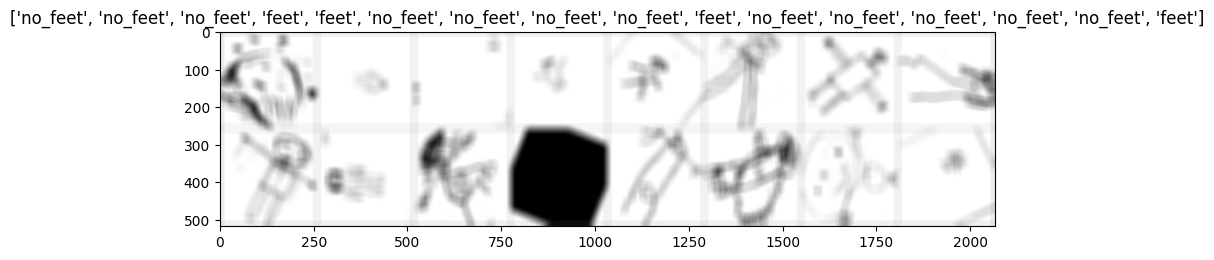

In [7]:
import torchvision
plt.rcParams["figure.figsize"] = (10,4)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders_v2['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
trans = torchvision.transforms.GaussianBlur(kernel_size=(23,29), sigma=(23,23))
# plt.fig
imshow(trans(out), title=[class_names[x] for x in classes])


## Model Building

<p>Using as reference: <a>https://pytorch.org/hub/pytorch_vision_resnet/</a>, <a>https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html</a></p>

In [9]:
import time
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    loss_dict = {"val_loss": [], "train_loss": []}
    acc_dict = {"val_acc": [], "train_acc": []}
 
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders_v2[phase]:
                

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes_v2[phase]
            epoch_acc = running_corrects.double() / dataset_sizes_v2[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == "val":
                loss_dict['val_loss'].append(float(f'{epoch_loss:.4f}'))
                acc_dict['val_acc'].append(float(f'{epoch_acc:.4f}'))
            if phase == "train":
                loss_dict['train_loss'].append(float(f'{epoch_loss:.4f}'))
                acc_dict['train_acc'].append(float(f'{epoch_acc:.4f}'))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, loss_dict, acc_dict

### Prediction Method

In [8]:
def visualize_model_test(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_v2['val']):
            # if torch.cuda.is_available():
            #     inputs, labels = inputs.cuda(), labels.cuda()
                
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                trans = torchvision.transforms.GaussianBlur(kernel_size=(15,15), sigma=(23,23))
                # imshow(inputs.cpu().data[j])
                imshow(trans(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Function for saving model

In [13]:
def saveModel(model, name: str, path): 
    path = f'{path}/{name}.pth' 
    torch.save(model, path) 

### Function for plotting graphs

In [12]:
def plot_(arr1, arr2, label, xvalues, modelName):
    plt.plot(xvalues, arr1, label = f"training")
    plt.plot(xvalues, arr2, label = f"validation")
    # naming the x axis
    plt.ylabel(label.lower())
    # naming the y axis
    plt.xlabel('epoch')
    # giving a title to my graph
    plt.title(f'Fine-tuned {modelName} {label.title()}')
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()

The following code will consist of fine-tuning each model. ResNet50, ResNet101 were trained on local machine. 

VGG16 and ResNet152 were trained on Google Colab.

Every model's history is stores at .txt file.

# ResNet101

### Fine-tuning ResNet101

In [ ]:
torch.cuda.empty_cache()

Uses cross entropy loss function, AdamW optimizer, and StepLR scheduler.

In [ ]:
from torch.optim import lr_scheduler

model_ft_resnet101 = models.resnet101(pretrained=True)
num_ftrs = model_ft_resnet101.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)). 
model_ft_resnet101.fc = nn.Linear(num_ftrs, 2)
# model_ft_resnet101
model_ft_resnet101 = model_ft_resnet101.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft_resnet101.parameters(), lr=5e-5, weight_decay=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\linda\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\linda\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train for 10 epoch

In [ ]:
model_ft_resnet101_10, loss_values_10epoch_101, accuracy_values_10epoch_101 = train_model(model_ft_resnet101, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6569 Acc: 0.6014
val Loss: 0.5353 Acc: 0.6927

Epoch 1/9
----------
train Loss: 0.5395 Acc: 0.7250
val Loss: 0.4348 Acc: 0.7933

Epoch 2/9
----------
train Loss: 0.4976 Acc: 0.7694
val Loss: 0.6371 Acc: 0.7151

Epoch 3/9
----------
train Loss: 0.4464 Acc: 0.7903
val Loss: 0.4578 Acc: 0.7654

Epoch 4/9
----------
train Loss: 0.4055 Acc: 0.8167
val Loss: 0.5808 Acc: 0.7542

Epoch 5/9
----------
train Loss: 0.4231 Acc: 0.8167
val Loss: 0.4231 Acc: 0.7877

Epoch 6/9
----------
train Loss: 0.3624 Acc: 0.8528
val Loss: 0.4735 Acc: 0.8212

Epoch 7/9
----------
train Loss: 0.3120 Acc: 0.8597
val Loss: 0.5336 Acc: 0.7598

Epoch 8/9
----------
train Loss: 0.2543 Acc: 0.9042
val Loss: 0.4078 Acc: 0.7989

Epoch 9/9
----------
train Loss: 0.2560 Acc: 0.9014
val Loss: 0.3634 Acc: 0.8547

Training complete in 18m 43s
Best val Acc: 0.854749


In [ ]:
saveModel(model=model_ft_resnet101_10, path=r"C:\Desktop\Project\feet_feature\code\models\experiment_1", name='model_ft_resnet101_10poch')

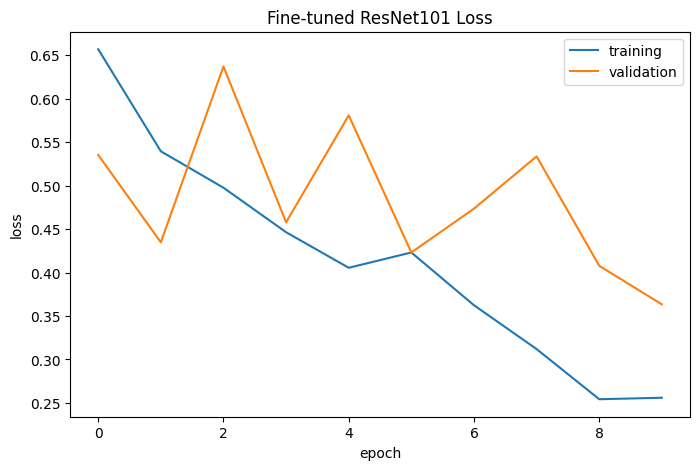

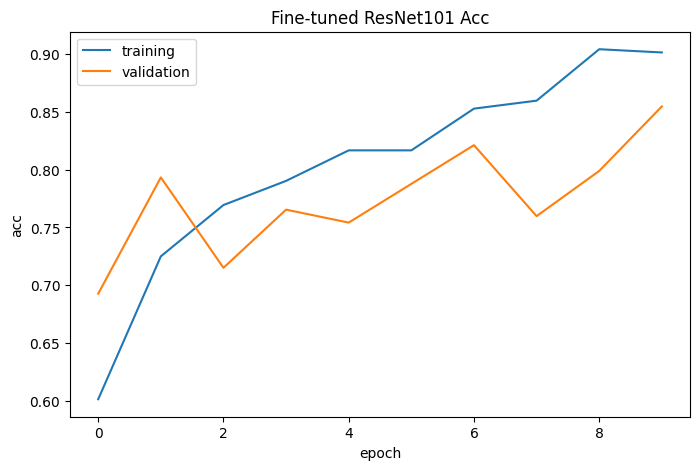

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
# accuracy_values_10epoch_101 = json.loads(accuracy_values_10epoch_101)
# loss_values_10epoch_101 = json.loads(loss_values_10epoch_101)
plot_(arr1=loss_values_10epoch_101['train_loss'], arr2=loss_values_10epoch_101['val_loss'], label='loss', xvalues=list(range(0, 10)), modelName='ResNet101')
plot_(arr1=accuracy_values_10epoch_101['train_acc'], arr2=accuracy_values_10epoch_101['val_acc'], label='acc', xvalues=list(range(0, 10)), modelName='ResNet101')

## Saving history of model's performance for analysis purposes.

In [ ]:
accuracy_values_10epoch_101 = json.dumps(accuracy_values_10epoch_101)
loss_values_10epoch_101 = json.dumps(loss_values_10epoch_101)
with open(r'C:\Desktop\Project\feet_feature\code\models\experiment_1\acc_10e.txt', 'w') as f1:
    f1.write(accuracy_values_10epoch_101)
with open(r'C:\Desktop\Project\feet_feature\code\models\experiment_1\loss_10e.txt', 'w') as f2:
    f2.write(loss_values_10epoch_101)

## ResNet50

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torch.optim import lr_scheduler
model_ft_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_ft_resnet50.fc.in_features
model_ft_resnet50.fc = nn.Linear(num_ftrs, 2)

model_ft_resnet50 = model_ft_resnet50.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.AdamW(model_ft_resnet50.parameters(), lr=5e-5, weight_decay=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train for 10 epoch.

In [ ]:
model_ft_resnet50_10e, loss_values_50_10e, accuracy_values_50_10e = train_model(model_ft_resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6508 Acc: 0.6056
val Loss: 0.5258 Acc: 0.7318

Epoch 1/9
----------
train Loss: 0.5766 Acc: 0.6778
val Loss: 0.4599 Acc: 0.8156

Epoch 2/9
----------
train Loss: 0.4691 Acc: 0.7819
val Loss: 0.5050 Acc: 0.7374

Epoch 3/9
----------
train Loss: 0.4512 Acc: 0.7931
val Loss: 0.5697 Acc: 0.7318

Epoch 4/9
----------
train Loss: 0.3971 Acc: 0.8292
val Loss: 0.4290 Acc: 0.8045

Epoch 5/9
----------
train Loss: 0.3940 Acc: 0.8264
val Loss: 0.3907 Acc: 0.8101

Epoch 6/9
----------
train Loss: 0.3160 Acc: 0.8708
val Loss: 0.3699 Acc: 0.8324

Epoch 7/9
----------
train Loss: 0.2222 Acc: 0.9167
val Loss: 0.3736 Acc: 0.8101

Epoch 8/9
----------
train Loss: 0.2416 Acc: 0.8903
val Loss: 0.4612 Acc: 0.8324

Epoch 9/9
----------
train Loss: 0.2355 Acc: 0.9028
val Loss: 0.4049 Acc: 0.8380

Training complete in 15m 57s
Best val Acc: 0.837989


In [ ]:
saveModel(model=model_ft_resnet50_10e, path=r"C:\Desktop\Project\feet_feature\code\models\experiment_1\Resnet50", name='model_ft_resnet50_10e')

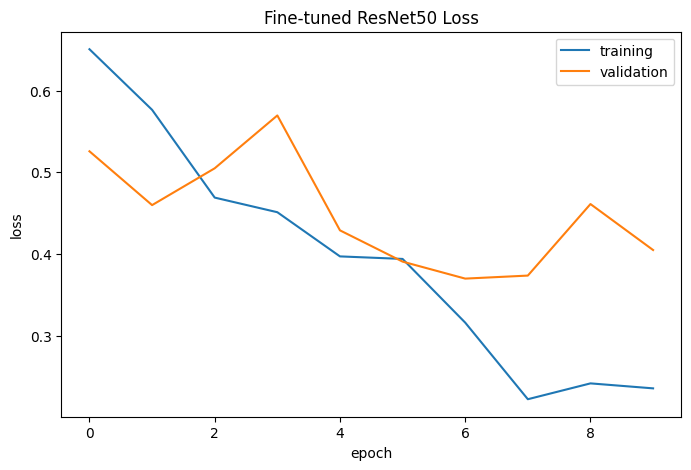

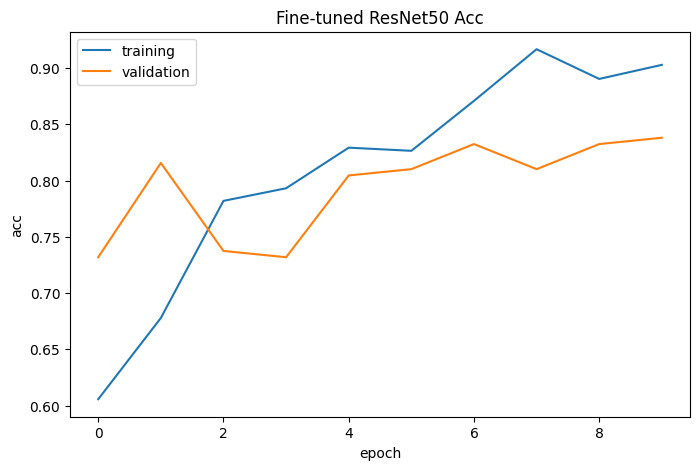

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plot_(arr1=loss_values_50_10e['train_loss'], arr2=loss_values_50_10e['val_loss'], label='loss', xvalues=list(range(0, 10)), modelName='ResNet50')
plot_(arr1=accuracy_values_50_10e['train_acc'], arr2=accuracy_values_50_10e['val_acc'], label='acc', xvalues=list(range(0, 10)), modelName='ResNet50')

In [ ]:
accuracy_values_50_10e = json.dumps(accuracy_values_50_10e)
loss_values_50_10e = json.dumps(loss_values_50_10e)
with open(r'C:\Desktop\Project\feet_feature\code\models\experiment_1\Resnet50\acc_10e.txt', 'w') as f1:
    f1.write(accuracy_values_50_10e)
with open(r'C:\Desktop\Project\feet_feature\code\models\experiment_1\Resnet50\loss_10e.txt', 'w') as f2:
    f2.write(loss_values_50_10e)

## ResNet152

This was ran on google colab.

In [ ]:
from torch.optim import lr_scheduler
# model.fc.in_features
model_ft_resnet152 = models.resnet152(pretrained=True)
num_ftrs = model_ft_resnet152.fc.in_features

model_ft_resnet152.fc = nn.Linear(num_ftrs, 2)

model_ft_resnet152 = model_ft_resnet152.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft_resnet152.parameters(), lr=5e-5, weight_decay=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 241MB/s]


Train for 10 epoch.

In [ ]:
model_ft_resnet152, resnet152_loss_values, resnet152_accuracy_values = train_model(model_ft_resnet152, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6212 Acc: 0.6319
val Loss: 0.5375 Acc: 0.7486

Epoch 1/9
----------
train Loss: 0.5197 Acc: 0.7514
val Loss: 0.3862 Acc: 0.8492

Epoch 2/9
----------
train Loss: 0.4872 Acc: 0.7792
val Loss: 0.5216 Acc: 0.7263

Epoch 3/9
----------
train Loss: 0.4702 Acc: 0.7583
val Loss: 0.5148 Acc: 0.7877

Epoch 4/9
----------
train Loss: 0.3969 Acc: 0.8083
val Loss: 0.4179 Acc: 0.8101

Epoch 5/9
----------
train Loss: 0.3554 Acc: 0.8319
val Loss: 0.4725 Acc: 0.7598

Epoch 6/9
----------
train Loss: 0.3589 Acc: 0.8403
val Loss: 0.5213 Acc: 0.8045

Epoch 7/9
----------
train Loss: 0.3251 Acc: 0.8653
val Loss: 0.4345 Acc: 0.7989

Epoch 8/9
----------
train Loss: 0.2584 Acc: 0.8819
val Loss: 0.4062 Acc: 0.8436

Epoch 9/9
----------
train Loss: 0.2362 Acc: 0.9111
val Loss: 0.4641 Acc: 0.8268

Training complete in 14m 48s
Best val Acc: 0.849162


In [ ]:
saveModel(model=model_ft_resnet152, path=f"/content/drive/MyDrive/feet_models_", name='model_ft_resnet152')

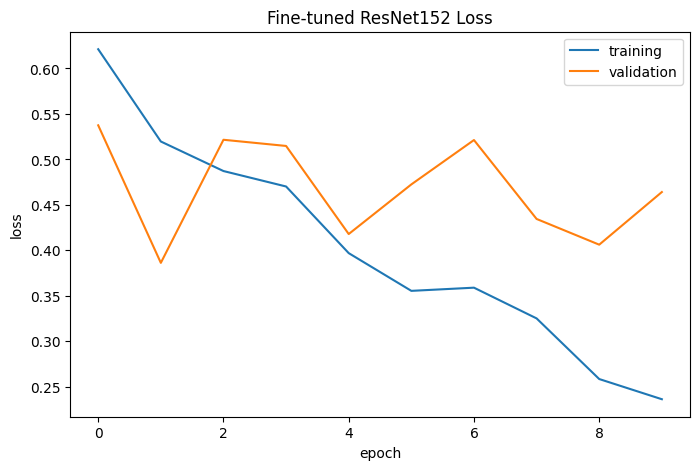

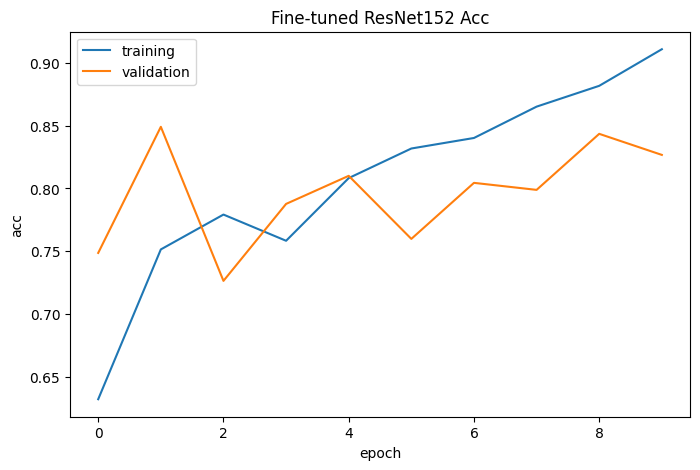

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plot_(arr1=resnet152_loss_values['train_loss'], arr2=resnet152_loss_values['val_loss'], label='loss', xvalues=list(range(0, 10)), modelName='ResNet152')
plot_(arr1=resnet152_accuracy_values['train_acc'], arr2=resnet152_accuracy_values['val_acc'], label='acc', xvalues=list(range(0, 10)), modelName='ResNet152')

In [ ]:
resnet152_accuracy_values = json.dumps(resnet152_accuracy_values)
resnet152_loss_values = json.dumps(resnet152_loss_values)
with open('/content/drive/MyDrive/feet_models_/acc.txt', 'w') as f1:
    f1.write(resnet152_accuracy_values)
with open('/content/drive/MyDrive/feet_models_/loss.txt', 'w') as f2:
    f2.write(resnet152_loss_values)

## VGG

This is the best performing model out of the previous model judging from its fit in the loss graph.

In [ ]:
from torch.optim import lr_scheduler

model_ft_vgg = models.vgg16(pretrained=True)

num_ftrs = model_ft_vgg.classifier[0].out_features

model_ft_vgg.fc = nn.Linear(num_ftrs, 2)

model_ft_vgg = model_ft_vgg.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft_vgg.parameters(), lr=0.001, momentum=0.9)
optimizer_ft= optim.AdamW(model_ft_vgg.parameters(),lr=5e-5, weight_decay=0.1)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

VGG16 model was trained for 15 epochs due to an observed good performance when firstly trained.

In [ ]:
model_ft_vgg, vgg_loss_values, vgg_accuracy_values = train_model(model_ft_vgg, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 1.7376 Acc: 0.5194
val Loss: 0.6305 Acc: 0.6536

Epoch 1/14
----------
train Loss: 0.7143 Acc: 0.6139
val Loss: 0.5502 Acc: 0.7430

Epoch 2/14
----------
train Loss: 0.6429 Acc: 0.6417
val Loss: 0.5477 Acc: 0.6872

Epoch 3/14
----------
train Loss: 0.6641 Acc: 0.6319
val Loss: 0.5769 Acc: 0.6983

Epoch 4/14
----------
train Loss: 0.5952 Acc: 0.6722
val Loss: 0.5106 Acc: 0.7374

Epoch 5/14
----------
train Loss: 0.5943 Acc: 0.6778
val Loss: 0.6043 Acc: 0.6369

Epoch 6/14
----------
train Loss: 0.5306 Acc: 0.7361
val Loss: 0.6120 Acc: 0.6425

Epoch 7/14
----------
train Loss: 0.4838 Acc: 0.7556
val Loss: 0.5045 Acc: 0.7318

Epoch 8/14
----------
train Loss: 0.4763 Acc: 0.7639
val Loss: 0.5211 Acc: 0.7486

Epoch 9/14
----------
train Loss: 0.4449 Acc: 0.7903
val Loss: 0.5555 Acc: 0.7374

Epoch 10/14
----------
train Loss: 0.4153 Acc: 0.8097
val Loss: 0.5106 Acc: 0.7374

Epoch 11/14
----------
train Loss: 0.4105 Acc: 0.8000
val Loss: 0.5327 Acc: 0.6927

Ep

In [ ]:
saveModel(model=model_ft_vgg, path="/content/drive/MyDrive/feet_models/VGG16", name='model_ft_vgg_15poch')

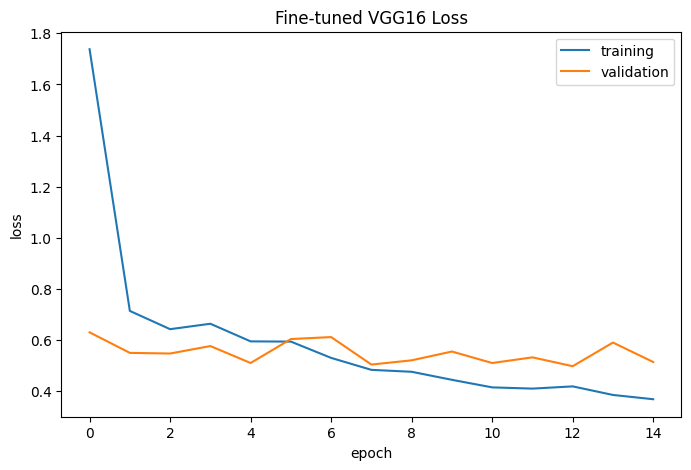

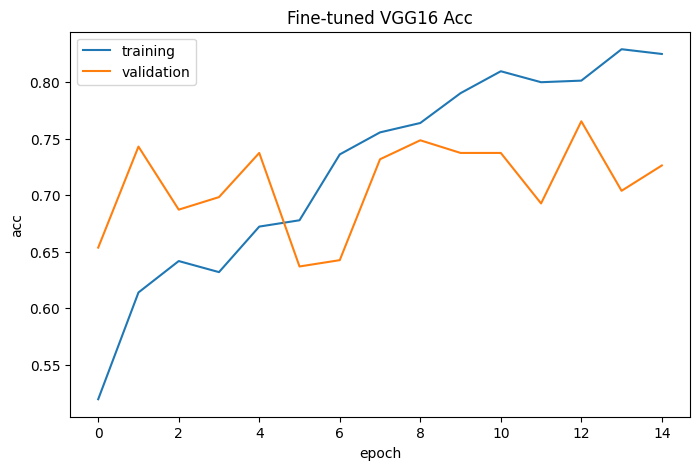

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plot_(arr1=vgg_loss_values['train_loss'], arr2=vgg_loss_values['val_loss'], label='loss', xvalues=list(range(0, 15)), modelName='VGG16')
plot_(arr1=vgg_accuracy_values['train_acc'], arr2=vgg_accuracy_values['val_acc'], label='acc', xvalues=list(range(0, 15)), modelName='VGG16')

In [ ]:
vgg_accuracy_values = json.dumps(vgg_accuracy_values)
vgg_loss_values = json.dumps(vgg_loss_values)
with open('/content/drive/MyDrive/feet_models/VGG16/acc_15e.txt', 'w') as f1:
    f1.write(vgg_accuracy_values)
with open('/content/drive/MyDrive/feet_models/VGG16/loss_15e.txt', 'w') as f2:
    f2.write(vgg_loss_values)

## Predictions of Tuned Models

The following will be in the order of loading the saved model and then calling "visualize_model_test" method to visualize the predictions of each model.

Images are blurred for confidentiality purposes.

### ResNet50

In [15]:
ResNet50_load = torch.load(r"C:\Desktop\Project\feet_feature\code\models\experiment_1\ResNet50\model_ft_resnet50_10e.pth")

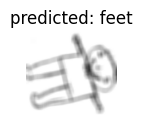

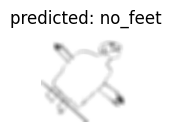

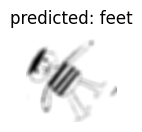

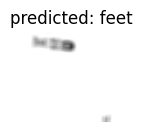

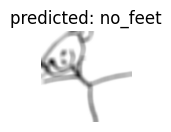

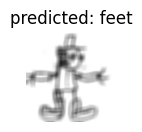

In [16]:
visualize_model_test(ResNet50_load)

### ResNet101

In [13]:
ResNet101_load = torch.load(r"C:\Desktop\Project\feet_feature\code\models\experiment_1\ResNet101\model_ft_resnet101_10poch.pth")

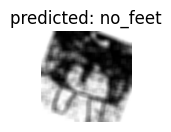

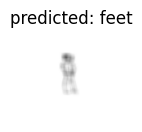

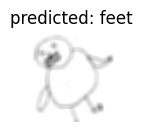

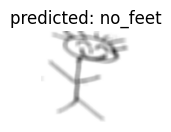

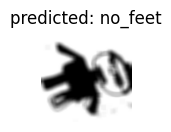

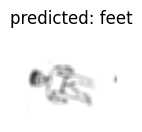

In [14]:
visualize_model_test(ResNet101_load)

## Resnet152

In [11]:
ResNet152_load = torch.load(r"C:\Desktop\Project\feet_feature\code\models\experiment_1\ResNet152\model_ft_resnet152.pth")

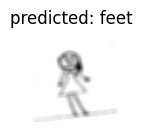

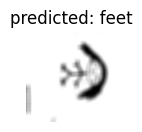

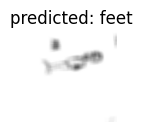

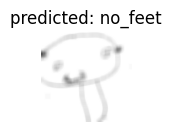

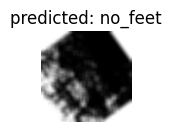

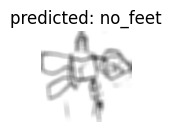

In [12]:
visualize_model_test(ResNet152_load)

# VGG

In [9]:
model_ft_vgg_load = torch.load(r"C:\Desktop\Project\feet_feature\code\models\experiment_1\VGG16\model_ft_vgg_15poch.pth")

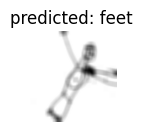

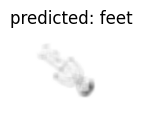

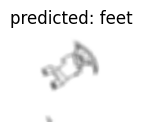

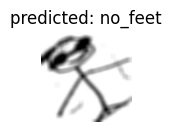

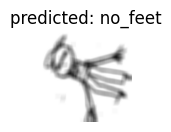

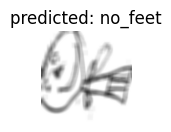

In [17]:
visualize_model_test(model_ft_vgg_load)